## ■  2. 가중치 초기값

가중치 초기화 값으로 Xavier 또는 He를 이용할 때의 각층의 활성화 값들의 분포가 정규성을 보이면  
학습이 효율적으로 이뤄질 수 있음을 기대할 수 있다. 

## 예제1. 어제 만들었던 3층 신경망의 가중치 초기화값을 Xavier로 구현하시오!

1/(n**0.5) * np.random.randn(784,50)   
n = 전층의 노드 수

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = 1/np.sqrt(input_size) * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = 1/np.sqrt(hidden_size1) * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = 1/np.sqrt(hidden_size2) * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50,hidden_size2=100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 예제2. he를 사용하여 3층 신경망을 구현하시오!

In [ ]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.sqrt(2/input_size) * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = np.sqrt(2/hidden_size1) * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = np.sqrt(2/hidden_size2) * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50,hidden_size2=100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## ■ 3. 배치 정규화(batch normalization) p.210

" 가중치 초기화 값을 적절히 설정하면 각 층의 활성화 값의 분포가 적당히 퍼지는 효과를 보이는데 신경망이 깊어지고 학습이 반복되다보면  
 각층의 활성화 값의 분포가 정규성을 잃어버리는 현상이 발생하게 됩니다.  
 그래서 이 정규성을 계속해서 유지시키도록 __'강제화'__하는 방법이 배치 정규화 입니다. "

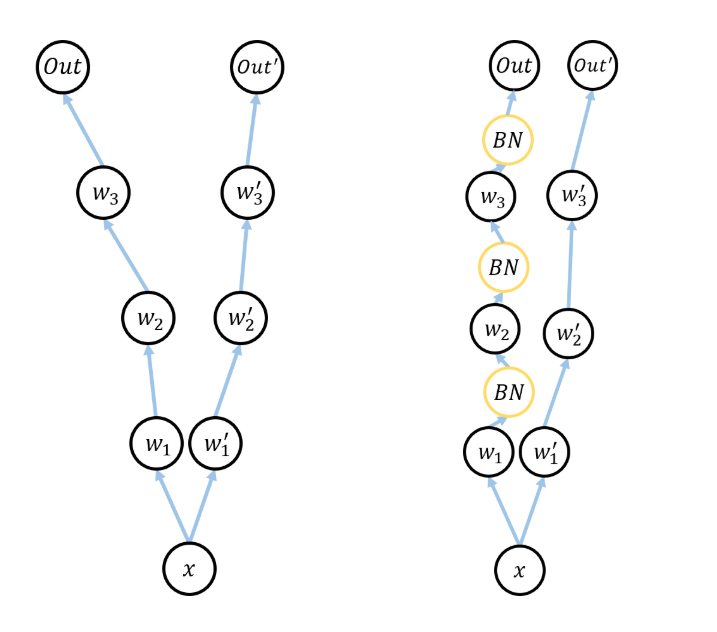

### ※ 배치 정규화의 장점이 무엇입니까? P.210

1. 학습을 빨리 진행 할 수 있다. (학습 속도가 개선)
2. 가중치 초기값에 크게 의존하지 않는다.
3. 오버피팅을 억제한다.( 드롭아웃 등으 필요성이 감소) 

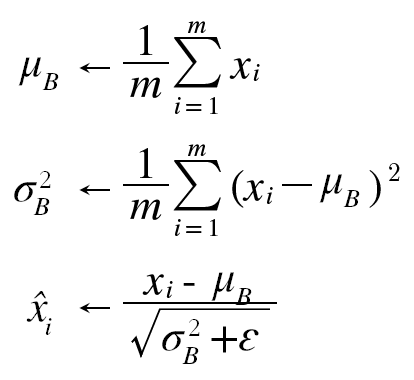


식 6.7

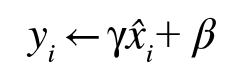

식 6.8

감마와 베타는 입력 데이터를 평균이 0, 분산이 1이 되도록 정규화를 유지 시키게 하는 매개변수입니다.  
감마는 __확대__이고 베타는 __이동__인데, 이 감마와 베타는 처음에는 감마 = 1 로 시작하고 베타 = 0 으로 시작합니다.    
입력데이터를 평균이 0, 분산이 1이 되도록 정규화를 하는데 학습을 통해서 새로운 감마와 베타값을 신경망이 내놓습니다.    
학습되면서 감마와 베타가 가중치처럼 신경망에 맞게 조정이 됩니다.  

## 예제1. 어제 만들었던 3층 신경망에 배치 정규화 코드를 구현하시오!

In [ ]:
    # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()
        
        # BatchNormalization이라는 클래스를 불러옴
        # common.layers 안에 클래스가 들어가 있음.

※ 저자가 만들어온 BatchNormarlization 클래스에는 학습된 감마와 베타를 저장하는 코드가 없다.  
훈련과 테스트를 동시에 하기 때문에 지금 상관없는데 훈련을 먼저하고 테스트를 나중에 할때는 정확도가 안나올 수 있다.

## 점심시간 문제:   
## 어제 마지막 문제의 4층 코드에 배치 정규화를 구현하고 어제보다 정확도가 올라가는지 확인하시오!

In [ ]:
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3'] = np.zeros(hidden_size3) 
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4'] = np.zeros(output_size)   

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, hidden_size3=100, output_size=10)

# 하이퍼파라미터
epoch=20 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Adam()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
 
    # 매개변수 갱신
   # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
   #     network.params[key] -= learning_rate * grad[key]



    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 학습을 올바르게 시키기 위한 5가지 방법들

1. 경사 감소법  
2. 가중치 초기화 값 선정  
3. 배치 정규화   
__----------------------__
4. 가중치 감소  
5. 드롭아웃  


1,2,3 -> 언더피팅  
4,5 -> 오버피팅  

## ■ 4. 가중치 감소

__" 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제하는 방법이다. "__

## ■ 가중치 감소를 코드로 구현하는 방법

    1. __init__ 함수 안에 람다를 정의한다.
    
    self.weight_decay_lambda = 0.001 # 인스턴스 변수를 추가
    
    2. 손실(loss)함수가 출력하는 loss에 1/2(lamda)w^2 를 더한다.

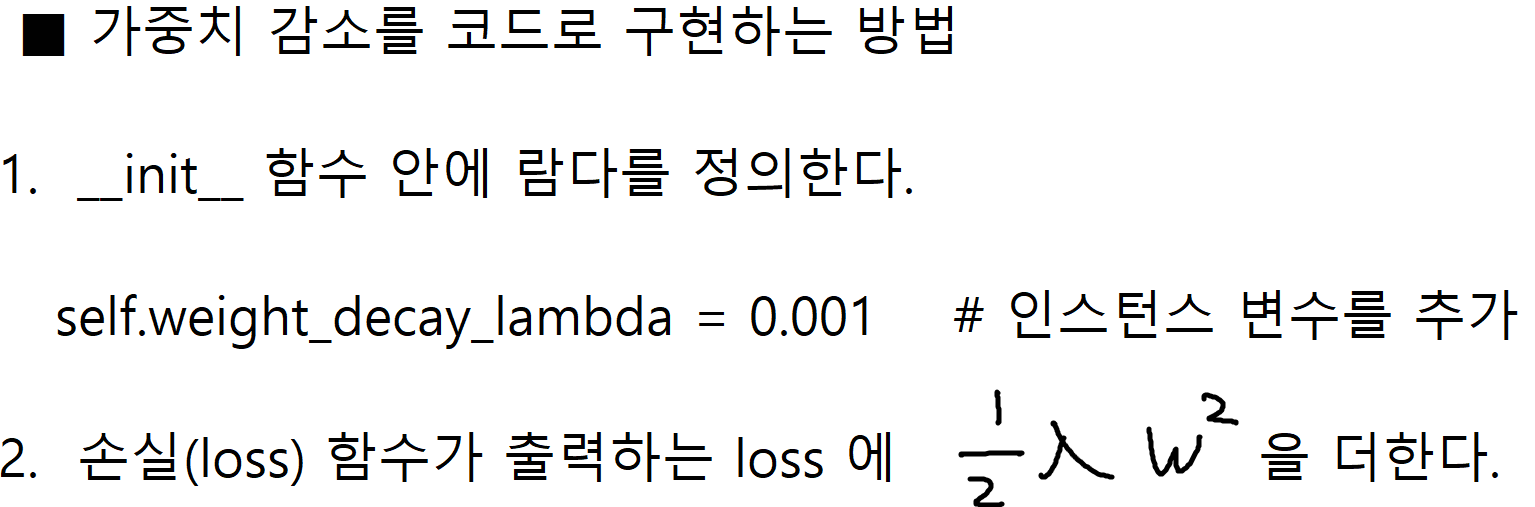

In [ ]:
def loss(self, x, t):  # x : (100, 1024), t : (100, 10)

        y = self.predict(x)  # (100, 10) : 마지막 출력층을 통과한 신경망이 예측한 값
        weight_decay = 0
        for idx in range(1, 4):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.lastLayer.forward(y, t) + weight_decay 

In [ ]:
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import *


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3'] = np.zeros(hidden_size3) 
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4'] = np.zeros(output_size)   

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma = 1.0, beta = 0.)
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.lastLayer = SoftmaxWithLoss()
        
        self.weight_decay_lambda = 0.001

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):  # x : (100, 1024), t : (100, 10)

        y = self.predict(x)  # (100, 10) : 마지막 출력층을 통과한 신경망이 예측한 값
        weight_decay = 0
        for idx in range(1, 4):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.lastLayer.forward(y, t) + weight_decay 

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, hidden_size3=100, output_size=10)

# 하이퍼파라미터
epoch=20 #int(input('에폭수를 입력하세요: '))
iters_num = 600*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Adam()

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)
 
    # 매개변수 갱신
   # for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
   #     network.params[key] -= learning_rate * grad[key]



    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 문제67. 
## 다시 가중치 초기화를 걷어내고 원래 코드로 구현하는데 
## 층을 책에 나온데로 7개의 층으로 만들고 노드당 뉴런수는 100개씩 구성해서 
## 7층 신경망을 생성하시오~ 
## 오버피팅이 발생하는지 확인하시오

In [ ]:
from common.optimizer import*
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)        
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b4'] = np.zeros(hidden_size)
        self.params['W5'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b5'] = np.zeros(hidden_size)
        self.params['W6'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b6'] = np.zeros(hidden_size)
        self.params['W7'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b7'] = np.zeros(output_size)
        self.weight_decay_lambda = 0.001
        # 계층 생성

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.layers['BatchNorm4'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu4'] = Relu()
        self.layers['Affine5'] = Affine(self.params['W5'], self.params['b5'])
        self.layers['BatchNorm5'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu5'] = Relu()
        self.layers['Affine6'] = Affine(self.params['W6'], self.params['b6'])
        self.layers['BatchNorm6'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu6'] = Relu()
        self.layers['Affine7'] = Affine(self.params['W7'], self.params['b7'])


        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    # x : 입력 데이터, t : 정답 레이블

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        grads['W5'], grads['b5'] = self.layers['Affine5'].dW, self.layers['Affine5'].db
        grads['W6'], grads['b6'] = self.layers['Affine6'].dW, self.layers['Affine6'].db
        grads['W7'], grads['b7'] = self.layers['Affine7'].dW, self.layers['Affine7'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]
network = TwoLayerNet(784,100,10)
# 하이퍼파라미터

epoch=20#int(input('에폭수를 입력하세요: '))
iter_per_epoch = max(train_size / batch_size, 1)
iters_num = iter_per_epoch*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수


optimizer = Adam()

for i in range(int(iters_num)): # 10000

    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번

    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)

    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)  

    # 매개변수 갱신
    #for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
    #    network.params[key] -= learning_rate * grad[key]
    # 학습 경과 기록고
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려
        print(loss)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 문제68. 성민이의 7층 신경망에 가중치 감소 코드를 추가한 후 오버피팅이 억제되는지 확인하시오!

In [ ]:
from common.optimizer import*
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)        
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b4'] = np.zeros(hidden_size)
        self.params['W5'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b5'] = np.zeros(hidden_size)
        self.params['W6'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b6'] = np.zeros(hidden_size)
        self.params['W7'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b7'] = np.zeros(output_size)
        self.weight_decay_lambda = 0.001
        # 계층 생성

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.layers['BatchNorm4'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu4'] = Relu()
        self.layers['Affine5'] = Affine(self.params['W5'], self.params['b5'])
        self.layers['BatchNorm5'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu5'] = Relu()
        self.layers['Affine6'] = Affine(self.params['W6'], self.params['b6'])
        self.layers['BatchNorm6'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu6'] = Relu()
        self.layers['Affine7'] = Affine(self.params['W7'], self.params['b7'])


        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    # x : 입력 데이터, t : 정답 레이블
    
    def loss(self, x, t):  # x : (100, 1024), t : (100, 10)
        y = self.predict(x)  # (100, 10) : 마지막 출력층을 통과한 신경망이 예측한 값
        weight_decay = 0
        for idx in range(1, 4):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.lastLayer.forward(y, t) + weight_decay 
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    # x : 입력 데이터, t : 정답 레이블

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        grads['W5'], grads['b5'] = self.layers['Affine5'].dW, self.layers['Affine5'].db
        grads['W6'], grads['b6'] = self.layers['Affine6'].dW, self.layers['Affine6'].db
        grads['W7'], grads['b7'] = self.layers['Affine7'].dW, self.layers['Affine7'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]
network = TwoLayerNet(784,100,10)
# 하이퍼파라미터

epoch=20#int(input('에폭수를 입력하세요: '))
iter_per_epoch = max(train_size / batch_size, 1)
iters_num = iter_per_epoch*epoch  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수


optimizer = Adam()

for i in range(int(iters_num)): # 10000

    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번

    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)

    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)  

    # 매개변수 갱신
    #for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
    #    network.params[key] -= learning_rate * grad[key]
    # 학습 경과 기록고
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려
        print(loss)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 가중치 초기화 값을 Xavier나 he로 하고 배치 정규화를 달아주면 오버피팅을 막을 수 있다.

## ■ 5. 드롭아웃(dropout) p.219

__" 오버피팅을 억제하기 위해서 뉴런을 임의로 삭제하면서 학습시키는 방법 "__

__면접문제 :__ 오버피팅이 주로 어느 경우에 발생합니까 ?  
__답변 :__ 매개변수가 많고 표현력이 높은 모델에서 발생합니다. 그리고 훈련데이터가 적을 때도 발생합니다.

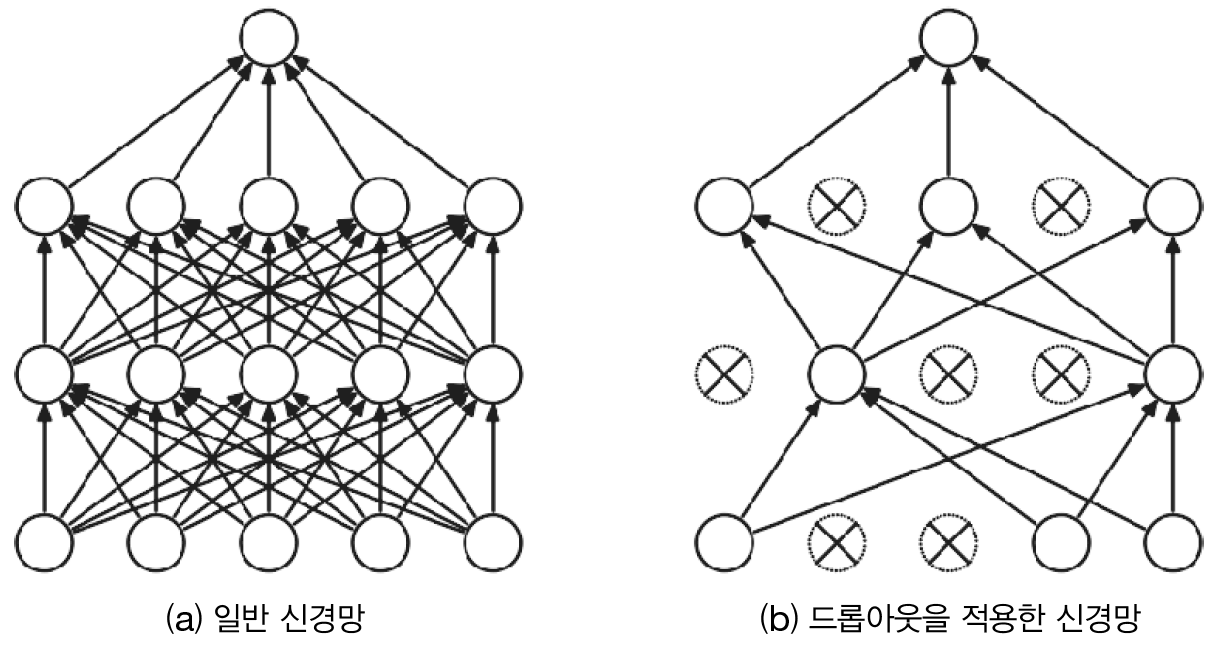

그림 6-22

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.15):
        self.dropout_ratio = dropout_ratio # 신경망에서 15%의 뉴런을 삭제하겠다.
        self.mask = None

    def forward(self, x, train_flg=True):
        # train_flg
        # 훈련할때는 드롭아웃 기능을 키고 
        # 테스트할때는 드롭아웃 기능을 끈다.
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            # 100% 중에 85%만 남겨두고 15%의 노드를 삭제하겠다.
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [ ]:
# Dropout을 실제로 적용

from common.optimizer import*
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)        
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b4'] = np.zeros(hidden_size)
        self.params['W5'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b5'] = np.zeros(hidden_size)
        self.params['W6'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b6'] = np.zeros(hidden_size)
        self.params['W7'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b7'] = np.zeros(output_size)
        self.weight_decay_lambda = 0.001
        # 계층 생성

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu1'] = Relu()
        self.layers['Dropout1'] = Dropout()

        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu2'] = Relu()
        self.layers['Dropout2'] = Dropout()
        
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.layers['BatchNorm4'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu4'] = Relu()
        self.layers['Dropout3'] = Dropout()
        
        self.layers['Affine5'] = Affine(self.params['W5'], self.params['b5'])
        self.layers['BatchNorm5'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu5'] = Relu()
        self.layers['Dropout4'] = Dropout()
 
        self.layers['Affine6'] = Affine(self.params['W6'], self.params['b6'])
        self.layers['BatchNorm6'] = BatchNormalization(gamma=1.0, beta = 0.)
        self.layers['Relu6'] = Relu()
        self.layers['Dropout5'] = Dropout()

        self.layers['Affine7'] = Affine(self.params['W7'], self.params['b7'])


        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):  # x : (100, 1024), t : (100, 10)

        y = self.predict(x)  # (100, 10) : 마지막 출력층을 통과한 신경망이 예측한 값
        weight_decay = 0
        for idx in range(1, 4):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.lastLayer.forward(y, t) + weight_decay 


    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    # x : 입력 데이터, t : 정답 레이블

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        grads['W5'], grads['b5'] = self.layers['Affine5'].dW, self.layers['Affine5'].db
        grads['W6'], grads['b6'] = self.layers['Affine6'].dW, self.layers['Affine6'].db
        grads['W7'], grads['b7'] = self.layers['Affine7'].dW, self.layers['Affine7'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]
network = TwoLayerNet(784,100,10)
# 하이퍼파라미터

epoch=20#int(input('에폭수를 입력하세요: '))
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)
iters_num = iter_per_epoch*epoch  # 반복 횟수를 적절히 설정한다.

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수


optimizer = Adam()

for i in range(int(iters_num)): # 10000

    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번

    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)

    grad = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params,grad)  

    # 매개변수 갱신
    #for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
    #    network.params[key] -= learning_rate * grad[key]
    # 학습 경과 기록고
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려
        print(loss)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# 원래 3층 신경망으로 come back(Xavier 사용한 3층 신경망)


           # coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.sqrt(2/input_size) * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = np.sqrt(2/hidden_size1)* np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = np.sqrt(2/hidden_size2) * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.lastLayer = SoftmaxWithLoss()
        
        self.weight_decay_lambda = 0.001

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):  # x : (100, 1024), t : (100, 10)

        y = self.predict(x)  # (100, 10) : 마지막 출력층을 통과한 신경망이 예측한 값
        weight_decay = 0
        for idx in range(1, 4):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.lastLayer.forward(y, t) + weight_decay 


    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size1=50,hidden_size2=100, output_size=10)

# 하이퍼파라미터

iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고

    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## ■ 7장. CNN(Convolution Neural Network) --> 합성곱 신경망

Convolution : 합성곱  
Neural : 신경  
Network : 망

### 합성곱 신경망? 

__" Convolution 층과 pooling 층을 포함하는 신경망 "__ 

### 기존 신경망과의 차이는?

    - 기존방법 : Affine ---> Relu(완전연결계층)
    - CNN : conv ---> Relu ---> Pooling ---> 완전연결계층( Affine --> Relu를 '완전연결계층'이라고 한다. )
    (conv ---> Relu ---> Pooling 층을 묶어서 cnn층이라고 한다.)

## ■ cnn을 이용하지 않은 기존층의 문제점?

__" 이미지의 형상이 무시된다. "__

http://cafe.daum.net/oracleoracle/ScIc/161

## 7장 CNN 이해를 돕기 위한 그림들

### 필기체 이미지

28x28 = 784의 1차원 데이터로 변경해서 784개의 데이터를 첫 affine 계층에 입력한게 기존 방법이다.

__문제점 :__ 형상을 무시하고 모든 입력 데이터를 동등한 뉴런으로 취급하기 때문에 이미지가 갖는 본질적인 패턴을 읽지 못한다.  
__해결방법:__ 원본이미지를 가지고 여러개의 feature map을 만들어서 데이터를 여러개를 생성한다. ( cnn층에서 )

## ■ 합성곱 연산을 컴퓨터로 구현하는 방법

원본 이미지 1장을 filter 100개로 합성곱 연산을 하면
feature map이 100개가 생성이 된다.